## Setup

In [24]:
import os

P_DATA = 'data'
P_SAVEDMODEL = 'model/checkpoints'
P_LOGS = 'logs'
P_OUTPUT = 'output'

dirs = [P_DATA, P_SAVEDMODEL, P_LOGS, P_OUTPUT]

for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)

In [25]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import keras
from keras import backend as K
import numpy as np
import os
import h5py
import matplotlib.pylab as plt
from model.ContextSeg import ContextSeg
from utils.colormap import label_defs
from utils.data_generator import *

In [4]:
# import multiprocessing as mp
# mp.set_start_method('spawn', force=True)

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [5]:
dataset = os.path.join(P_DATA, 'cihp_dataset.h5')
model_save_path = os.path.join(P_SAVEDMODEL, # path to save the model
                               'dataweights.{epoch:02d}-{val_acc:.2f}.hdf5')

input_shape = (320, 320, 3)
batch_size = 8
num_classes = 20
epochs = 80

In [11]:
import os
import tarfile
import numpy as np
import h5py
from tqdm import tqdm

def extract_from_tar(tar_file):
    tar = tarfile.open(tar_file)
    
    fmap = {'Training': 'train', 'Validation': 'val', 'Testing': 'test'}
    tmap = {'Images': 'x', 'Categories': 'y'}
    keys = {'x_train', 'y_train', 'x_val', 'y_val', 'x_test'}
    ext_data = dict((k, {}) for k in keys)
    
    for tarinfo in tqdm(tar.getmembers()): 
        path = tarinfo.name # file path
        splits = os.path.normpath(path).split(os.path.sep)
    
        if (len(splits) >= 4 and splits[1] in fmap and splits[-2] in tmap):
            
            content = tar.extractfile(tarinfo).read()
            key =  tmap[splits[-2]] + '_' + fmap[splits[1]]
            basename = os.path.splitext(splits[-1])[0] # without extension
        
            ext_data[key][basename] = content
    return ext_data


def binary2uint(data):
    return np.frombuffer(data, dtype='uint8')

ext_data = extract_from_tar('CIHP_instance-level_human_parsing.tar.gz')
x_train, y_train, x_val, y_val, x_test = [], [], [], [], []
i=0
for i, (k, v) in enumerate(tqdm(ext_data['x_train'].items(),
                                    'Processing train set..')):
    i+=1
    if i>1000:
        continue
    x_train += [binary2uint(v)]
    y_train += [binary2uint(ext_data['y_train'][k])]
i=0
for i, (k, v) in enumerate(tqdm(ext_data['x_val'].items(),
                                    'Processing val set..')):
    i+=1
    if i>1000:
        continue
    x_val += [binary2uint(v)]
    y_val += [binary2uint(ext_data['y_val'][k])]
i=0
for i, (k, v) in enumerate(tqdm(ext_data['x_test'].items(),
                                    'Processing test set..')):
    i+=1
    if i>1000:
        continue
    x_test += [binary2uint(v)]
    
ext_data.clear()

Processing test set..: 100%|██████████| 5000/5000 [00:00<00:00, 629076.40it/s]


In [13]:
len(x_train)

1000

## Train

In [14]:
# class MyFile:
#     def __init__(self, path):
#         self.fd = os.open(path, os.O_RDONLY)
#         self.pos = 0

#     def seek(self, pos, whence=0):
#         if whence == 0:
#             self.pos = pos
#         elif whence == 1:
#             self.pos += pos
#         else:
#             self.pos = os.lseek(self.fd, pos, whence)
#         return self.pos

#     def tell(self):
#         return self.pos

#     def read(self, size):
#         b = os.pread(self.fd, size, self.pos)
#         self.pos += len(b)
#         return b

In [19]:
hf = h5py.File(dataset, 'r', libver='latest', swmr=True)

seed=1
datagen_args = dict(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.7, 1.4],
#     zoom_range=0.1,
    shear_range=0.05,
    channel_shift_range=30,
    horizontal_flip=True,
    rescale=1/255,
    fill_mode='reflect'
)

train_generator = build_data_generators(
    x_train, y_train, datagen_args=datagen_args,
    input_dim=input_shape, batch_size=batch_size,
    colormap=label_defs, seed=seed)

val_generator = build_data_generators(
    x_val, y_val, datagen_args=datagen_args,
    input_dim=input_shape, batch_size=batch_size,
    colormap=label_defs, seed=seed)

test_generator = build_data_generators(
    x_test, datagen_args=datagen_args,
    input_dim=input_shape, batch_size=batch_size,
    colormap=label_defs, seed=seed)

In [20]:
# ImageDataGenerator()
X, y= next(train_generator)

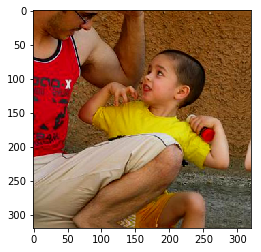

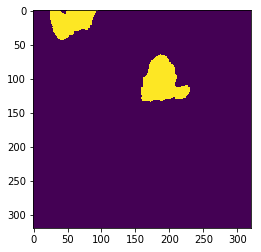

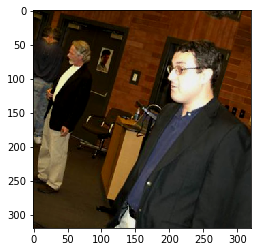

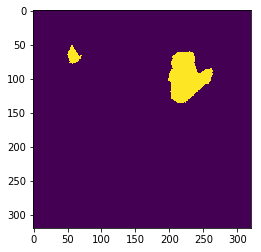

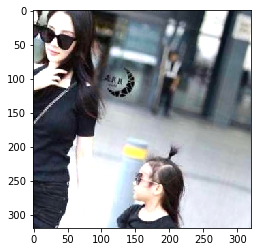

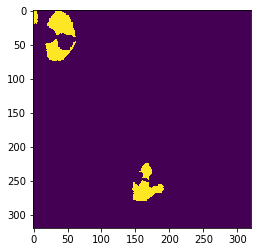

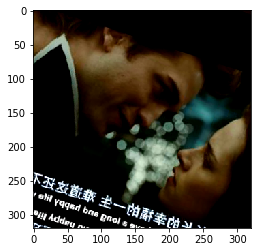

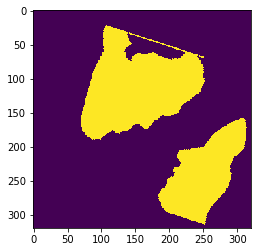

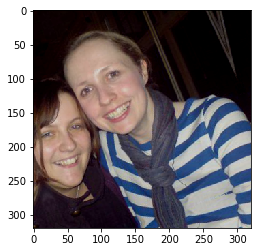

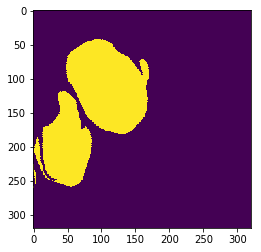

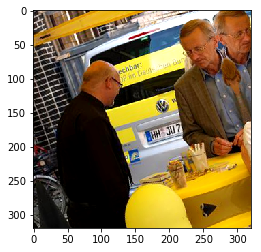

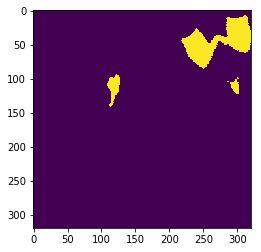

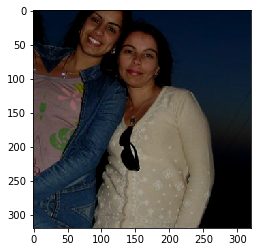

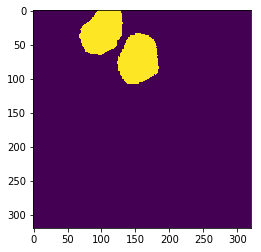

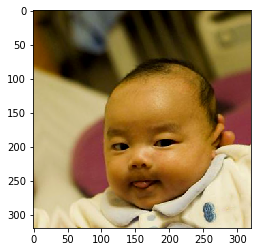

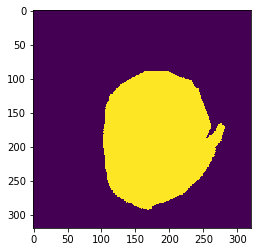

In [18]:
for i in range(batch_size):
    plt.figure(2*i)
    plt.imshow(X[0][i])
    plt.figure(2*i+1)
    plt.imshow(y[i,..., 13])

In [21]:
model = ContextSeg(input_shape, num_classes)
opt = keras.optimizers.RMSprop(lr=5e-5, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [22]:
modelchk = keras.callbacks.ModelCheckpoint(model_save, 
                                      monitor='val_loss', 
                                      verbose=1,
                                      save_best_only=True, 
                                      save_weights_only=False,
                                      mode='auto',
                                      period=3)

tensorboard = keras.callbacks.TensorBoard(log_dir=P_LOGS,
                                          histogram_freq=0,
                                          write_graph=True,
                                          write_images=True)

csv_logger = keras.callbacks.CSVLogger(os.path.join(P_LOGS, 'keras_log.csv'),
                                       append=True)

In [23]:
model.predict_generator(test_generator, verbose=1, use_multiprocessing=True, workers=8);

  7/125 [>.............................] - ETA: 15:21

Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/blaze/anaconda3/envs/chollet/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/blaze/anaconda3/envs/chollet/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/blaze/anaconda3/envs/chollet/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/blaze/anaconda3/envs/chollet/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "

KeyboardInterrupt: 

In [315]:
model.fit_generator(train_generator,
                    epochs=epochs,
                    steps_per_epoch=len(hf['x_train']) // batch_size,
                    verbose=1, 
                    validation_data=val_generator,
                    validation_steps=len(hf['x_val']) // batch_size,
                    callbacks=[modelchk, tensorboard, csv_logger])
#                     use_multiprocessing=True,
#                     workers=8)

KeyboardInterrupt: 

## Evaluation

In [ ]:
ls data/test/Images/

In [ ]:
ls data/val -R

In [ ]:
(train_images, valid_images, test_images, 
 num_classes, label_colors) = dp.load_data(data_dir,
                                           images_folder,
                                           masks_folder)

In [ ]:
valid_generator = DataGenerator(valid_images, batch_size, 
                                image_shape, target_shape, 
                                dp.label_defs)

In [ ]:
len(valid_generator)

In [ ]:
valid_generator = DataGenerator(valid_images[:150], batch_size, 
                                image_shape, target_shape, 
                                dp.label_defs)

train_generator = DataGenerator(train_images[:150], batch_size, 
                                image_shape, target_shape, 
                                dp.label_defs)

In [ ]:
len(valid_generator)

In [ ]:
from glob import glob

models=sorted(list(glob('Weights/*.hdf5') ))
models

In [ ]:
scores= {key: [] for key in ['acc', 'val_acc', 'loss', 'val_loss'] }
scores

In [ ]:
from keras.models import load_model

for path in models[6:]:
    model = load_model(path)
    
    ret = model.evaluate_generator(valid_generator, verbose=1, workers=4, use_multiprocessing=True)
    scores['val_acc'].append(ret[1])
    scores['val_loss'].append(ret[0])
    print(path, ret)
    ret = model.evaluate_generator(train_generator, verbose=1, workers=4, use_multiprocessing=True)
    scores['acc'].append(ret[1])
    scores['loss'].append(ret[0])
    print(path, ret)



In [ ]:
scores

In [ ]:
scores

In [ ]:
del sc['acc'][15]
del sc['loss'][15]
del sc['val_acc'][15]
del sc['val_loss'][15]
sc

In [ ]:
sc['val_loss'].index(0.5868370516432656)

In [ ]:
sc['acc'][22], sc['loss'][22], sc['val_acc'][22], sc['val_loss'][22] = (sc['acc'][20]+sc['acc'][23])/2, (sc['loss'][20]+sc['loss'][23])/2, (sc['val_acc'][20]+sc['val_acc'][23])/2, (sc['val_loss'][20]+sc['val_loss'][23])/2

In [ ]:
sc['acc'][21], sc['loss'][21], sc['val_acc'][21], sc['val_loss'][21] = sc['acc'][22], sc['loss'][22], sc['val_acc'][22], sc['val_loss'][22] 

In [ ]:
# sc = scores.copy()
sc['acc'].insert(-1, 0.822084774573644)
sc['loss'].insert(-1, 0.5236853526698219)
sc['val_acc'].insert(-1, 0.81689453125)
sc['val_loss'].insert(-1, 0.5516762369208865)
sc

In [ ]:
sc

In [ ]:
evalModel(scores)

In [ ]:
import seaborn as sns

plt.style.use('ggplot')


def plot2D(points, title, labelX, labelY, legends=None, save=None):
    plt.plot(points[0],'r')
    plt.plot(points[1],'g')
    plt.xlabel(labelX, fontsize=11)
    plt.ylabel(labelY, fontsize=11)
    plt.title(title, fontname="Comic Sans MS Bold", fontsize=14)
    plt.legend(legends)
    # plt.rcParams['figure.figsize'] = (7, 5)
    if save:
        plt.savefig(save)
    plt.show()
    
    
def evalModel(history, save=None):
    h = history
    if save:
      sv1 = os.path.join(P_PLOT, save + '_loss.png')
      sv2 = os.path.join(P_PLOT, save + '_acc.png')
    else:
      sv1, sv2 = None, None
      
    
    plt.figure(0)
    plot2D((h['loss'], h['val_loss']), 'Training and validation loss',
           'Epochs', 'Loss', ['train', 'val'], save=sv1)
    
    plt.figure(1)
    plot2D((h['acc'], h['val_acc']), 'Training and validation accuracy',
           'Epochs', 'Accuracy', ['train', 'val'], save=sv2)
    

In [ ]:

from glob import glob
import data_processing as dp

output_dir='pred/'
test_dir='data/test/Images'
image_shape = (384, 512, 3)
target_shape =(48, 64)
batch_size=8
num_classes=20

test_images=sorted(list(glob( os.path.join(test_dir, '*.jpg') )))

label_colors = {i: np.array(l.color) for i, l in enumerate(dp.label_defs)}

In [ ]:
from keras.models import load_model

model = load_model('weights.39-0.56.hdf5')

In [ ]:
test_images

In [ ]:
from skimage.transform import rescale, resize
import skimage.io as io


N=1000

images = np.empty((N, *image_shape)) 
images_low_res = np.empty((N, 
                           image_shape[0] // 4, image_shape[1] // 4,
                           3))

masks = np.empty((N, *target_shape, 3)) 


for i in range(N):
    print(i)
    images[i] = resize(io.imread(test_images[i]), image_shape,
                       mode='reflect')#, anti_aliasing=True)

    images_low_res[i] = rescale(images[i], 1 / 4, mode='reflect')
                               # multichannel=True, anti_aliasing=True) 

In [ ]:
import time

In [ ]:
s_time = time.time()

predicted = model.predict([images, images_low_res])

e_time = time.time()
print('Running time on {} images: {:3.3f}'.format(len(images),
                                                  e_time - s_time))

In [ ]:
print(f'FPS: {len(images) / (e_time - s_time): 3.3f}')

In [ ]:
for i in range(N):
    labels = np.argmax(predicted[i], axis=-1)
    labels = labels.reshape(target_shape)
    labels_colored = np.zeros((*target_shape, 3)) 
                
    for label, color in label_colors.items():
        labels_colored[labels == label] = color
    
    final_out = resize(labels_colored, image_shape)
    
    basename = os.path.splitext(os.path.basename(test_images[i]))[0]
    masks[i] = labels_colored
    io.imsave(os.path.join(output_dir, basename + '.png'), final_out / 255)

## Analysis

In [ ]:
ls Weights/ -R

In [ ]:
nrows = len(label_defs)


def plot_color_gradients(cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows, figsize=(10, 7))
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title('CIHP Colormap', fontsize=14, color='black')

    for ax, label in zip(axes, cmap_list):
        ax.imshow([[label.color]], aspect='auto', vmin=0, vmax=255)
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, label.name, 
                 va='center', ha='right', 
                 fontsize=12, color='black')

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()


plot_color_gradients(label_defs, nrows)
plt.show()


In [ ]:
classes = [0, 2, 7, 9, 13, 15, 19]
N=len(test_images)

fig, axes = plt.subplots(nrows=N, ncols=len(classes)+1, figsize=(22, 20))
fig.subplots_adjust(top=0.95, bottom=0, left=0.1, right=0.99, wspace = 0.1, hspace = 0)


for i in range(N):
    axes[i][0].imshow(images[i])
    if i == 0:
        axes[i][0].text(0, -85,
                    'Original',
                    fontsize=21,
                    color='black', va='top')

    axes[i][0].set_axis_off()
    for j, ax in enumerate(axes[i][1:]):
        ax.imshow(predicted[i, :,:, classes[j]], cmap='viridis')
        if i == 0:
            ax.text(0, -10,
                    dp.label_defs[classes[j]].name if classes[j] != 0 else 'Background',
                    fontsize=21,
                    color='black', va='top')
        ax.set_axis_off()
        
plt.show()